In [1]:
import os

!git clone https://github.com/Woodman718/FixCaps.git

if not os.path.exists("/content/dataset"):
    !gdown 1unYoVuSLU0amPRsZGbDv9n58LIuENYFO
    !unzip data.zip -d dataset

%load_ext autoreload
%autoreload 2

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/Malignant/1530.jpg  
  inflating: dataset/train/Malignant/1531.jpg  
  inflating: dataset/train/Malignant/1532.jpg  
  inflating: dataset/train/Malignant/1533.jpg  
  inflating: dataset/train/Malignant/1534.jpg  
  inflating: dataset/train/Malignant/1535.jpg  
  inflating: dataset/train/Malignant/1536.jpg  
  inflating: dataset/train/Malignant/1537.jpg  
  inflating: dataset/train/Malignant/1538.jpg  
  inflating: dataset/train/Malignant/1539.jpg  
  inflating: dataset/train/Malignant/154.jpg  
  inflating: dataset/train/Malignant/1540.jpg  
  inflating: dataset/train/Malignant/1541.jpg  
  inflating: dataset/train/Malignant/1542.jpg  
  inflating: dataset/train/Malignant/1543.jpg  
  inflating: dataset/train/Malignant/1544.jpg  
  inflating: dataset/train/Malignant/1545.jpg  
  inflating: dataset/train/Malignant/1546.jpg  
  inflating: dataset/train/Malignant/1547.jpg  
  inflating: dataset/train/Malignant/1

In [2]:
import torch
import sys, os
import json
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

import prettytable
import time
import sys
sys.setrecursionlimit(15000)

from PIL import Image
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.utils.data import random_split

from FixCaps.Module.model410 import FixCapsNet
from FixCaps.Module.images_show_410 import ImageShow

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc= 0.
#defined
try:
    print(len(test_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list=train_loss_list,
                train_acc_list=train_acc_list,
                test_loss_list=test_loss_list,
                test_acc_list=test_acc_list,
                test_auc_list=test_auc_list,
                val_loss_list=val_loss_list,
                val_acc_list=val_acc_list,
                )

In [4]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((308,308)),
                               transforms.CenterCrop((299, 299)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
    }

In [5]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
image_path = os.path.abspath(os.path.join(root_path,"content/dataset"))
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                                      transform=data_transform["val"])
train_num = len(train_dataset)
test_num = len(test_dataset)

img_sample = Image.open(test_dataset.imgs[1][0])
n_channels = np.array(img_sample).shape[2]#(H,W,C)

data_list = train_dataset.class_to_idx #
cla_dict = dict((val, key) for key, val in data_list.items())
n_classes  = len(data_list)
print(f'Using {n_classes} types.')

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(f'{img_title}.json', 'w') as json_file:#class_indices
    json_file.write(json_str)

BatchSize = 128
T_size = 31
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 10])
print(f'Using {nw} dataloader workers every process.')
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,pin_memory=pin_memory,
                                           shuffle=True, num_workers=nw)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=T_size,pin_memory=pin_memory,
                                          shuffle=False, num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num, test_num))

Using 2 types.
Using 10 dataloader workers every process.
using 11879 images for training, 2000 images for validation.


In [6]:
# Create capsule network.
conv_outputs = 128 #128_Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6
output_unit_size = 16
img_size = 299
network = FixCapsNet(conv_inputs= n_channels,
                     conv_outputs=conv_outputs,
                     num_primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     output_unit_size=output_unit_size,
                     num_classes=n_classes,
                     init_weights=True,mode="128")

network = network.to(device)
summary(network,(n_channels,img_size,img_size))
# network

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 135, 135]         369,024
              ReLU-2        [-1, 128, 135, 135]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(31, 31), stride=(2, 2), bias=False)
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
def confusion_matrix(evl_result):

    plt.style.use("seaborn")#classic
    plt.yticks(range(n_classes),cla_dict.values())
    plt.xticks(range(n_classes),cla_dict.values())
    plt.title("Confusion Matrix")
    plt.imshow(evl_result,cmap=plt.cm.Greens)
    for i in range(len(evl_result)):
        for j in range(len(evl_result[i])):
            plt.text(j,i,int(evl_result[i][j]))

    plt.colorbar()
    plt.savefig(f"./tmp/{img_title}/{suf}/Confusion Matrix.png",dpi=128)

In [10]:
def self_scores(opt="scores"):
    result_table = prettytable.PrettyTable()
    result_table.field_names = ['Type','Precision', 'Recall', 'F1','Accuracy']
    accuracy = float(torch.sum(evl_result.diagonal())/torch.sum(evl_result))

    for i in range(n_classes):
        pre = float(evl_result[i][i] / torch.sum(evl_result,0)[i])#
        recal = float(evl_result[i][i] / torch.sum(evl_result,1)[i])#torch.sum(result_table[i])
        F1 = pre * recal * 2 / (pre + recal + 1e-7)
        result_table.add_row([cla_dict[i], round(pre, 4), round(recal, 3), round(F1, 3)," "])

    result_table.add_row(["Total:", " ", " ", " ",round(accuracy,4)])
    print(result_table)

In [11]:
# Converts batches of class indices to classes of one-hot vectors.
def to_one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

In [12]:
def train(epoch):
    network.train()
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    print(f'Epoch: [{epoch}] {img_title} ==> Training ...')

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # target = torch.as_tensor(target, dtype=torch.int64)#for windows

        batch_idx += 1
        target_indices = target
        target_one_hot = to_one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        optimizer.zero_grad()
        output = network(data)

        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()

        loss = network.loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f}, ACC:{:.5f}%".format(batch_idx,len(train_loader),
                                                           loss,
                                                           r_pre/(batch_idx*BatchSize),))
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    print(f'Train_Loss: {epoch_loss},ACC:{round(float(epoch_acc),3)}%')
    scheduler.step()

In [21]:
def test():
    network.eval()
    global best_acc,evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,tmp_size, Acc=  0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    steps_num = len(test_loader)#len(test_loader) * T_size
    tmp_size = T_size
    print(f'\033[66m{img_title} ==> testing ...\033[0m')
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

            batch_idx +=1
            target_indices = target
            #torch.Size([128, 7]),tensor([[0., 0., 0., 0., 0., 1., 0.],...,[0., 0., 0., 0., 0., 1., 0.]])
            target_one_hot = to_one_hot(target_indices, length=n_classes)
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
            output = network(data)#torch.Size([batch_size, 7, 16, 1])
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]

            if batch_idx % steps_num == 0 and test_num % T_size != 0:
                tmp_size = test_num % T_size

            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred[i]] +=1

    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result)
    accuracy = 100. * float(torch.div(diag_sum,all_sum))
    test_acc_list.append(accuracy)

    print(f"Test_Acc:\033[1;32m{round(float(accuracy),3)}%\033[0m")

    if accuracy > best_acc:
        best_acc = accuracy
        evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
        torch.save(network.state_dict(), save_PATH)
        torch.save(evl_result, f'/best_evl_result.pt')

    print(f'Best_ACC[\033[1;32m{round(float(best_acc),3)}%\033[0m]')

In [19]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: ./tmp/{img_title}/{suf}')
else:
#     !mkdir -p ./tmp/{img_title}/{suf} #linux
    !md E:\Jupyter\woodman\Caps\FixCaps\tmp\{img_title}\{suf} #windows
save_PATH = f'model.pth'
print(save_PATH)

suf:0829_234419
/bin/bash: line 1: md: command not found
model.pth


In [15]:
num_epochs = 200

In [22]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()
print('Finished Training')

Epoch: [1] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11693, ACC:0.80639%
[92/93] Loss0.11341, ACC:0.80435%
Train_Loss: 0.12608054736929555,ACC:0.804%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.5%
Best_ACC[96.5%]
Epoch: [2] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11968, ACC:0.80690%
[92/93] Loss0.14842, ACC:0.81046%
Train_Loss: 0.11906086453186568,ACC:0.811%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.65%
Best_ACC[96.5%]
Epoch: [3] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11594, ACC:0.81929%
[92/93] Loss0.10705, ACC:0.81938%
Train_Loss: 0.11467459741779552,ACC:0.819%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.9%
Best_ACC[97.9%]
Epoch: [4] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.12275, ACC:0.81607%
[92/93] Loss0.08955, ACC:0.81963%
Train_Loss: 0.11289284370278799,ACC:0.82%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.95%
Best_ACC[97.95%]
Epoch: [5] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.16846, ACC:0.81946%
[92/93] Loss0.11398, ACC:0.81929%
Train_Loss: 0.11309420141161129,ACC:0.819%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.8%
Best_ACC[97.95%]
Epoch: [6] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10933, ACC:0.81861%
[92/93] Loss0.10678, ACC:0.81776%
Train_Loss: 0.11591999697428877,ACC:0.818%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.4%
Best_ACC[97.95%]
Epoch: [7] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.13669, ACC:0.82337%
[92/93] Loss0.11555, ACC:0.82091%
Train_Loss: 0.11421412117378686,ACC:0.821%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.15%
Best_ACC[97.95%]
Epoch: [8] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10322, ACC:0.81097%
[92/93] Loss0.12489, ACC:0.81870%
Train_Loss: 0.11488115843585743,ACC:0.819%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.7%
Best_ACC[97.95%]
Epoch: [9] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.15015, ACC:0.81641%
[92/93] Loss0.13127, ACC:0.82422%
Train_Loss: 0.11240293846655917,ACC:0.824%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.25%
Best_ACC[97.95%]
Epoch: [10] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10422, ACC:0.83424%
[92/93] Loss0.11492, ACC:0.83101%
Train_Loss: 0.10822495561774059,ACC:0.831%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.75%
Best_ACC[97.95%]
Epoch: [11] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10813, ACC:0.83203%
[92/93] Loss0.15326, ACC:0.83415%
Train_Loss: 0.10477080148073935,ACC:0.834%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.4%
Best_ACC[97.95%]
Epoch: [12] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09911, ACC:0.83832%
[92/93] Loss0.11987, ACC:0.83730%
Train_Loss: 0.10253297361314938,ACC:0.837%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.65%
Best_ACC[97.95%]
Epoch: [13] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11822, ACC:0.83679%
[92/93] Loss0.11403, ACC:0.84061%
Train_Loss: 0.10047427933382731,ACC:0.841%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.45%
Best_ACC[97.95%]
Epoch: [14] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09128, ACC:0.84001%
[92/93] Loss0.08392, ACC:0.84001%
Train_Loss: 0.10047987760395131,ACC:0.84%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.55%
Best_ACC[97.95%]
Epoch: [15] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10113, ACC:0.84392%
[92/93] Loss0.09987, ACC:0.84112%
Train_Loss: 0.09989906815431451,ACC:0.841%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.2%
Best_ACC[97.95%]
Epoch: [16] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11115, ACC:0.84426%
[92/93] Loss0.10155, ACC:0.84069%
Train_Loss: 0.10187061251171174,ACC:0.841%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.0%
Best_ACC[97.95%]
Epoch: [17] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09796, ACC:0.83560%
[92/93] Loss0.11904, ACC:0.83798%
Train_Loss: 0.10319074235295736,ACC:0.838%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.75%
Best_ACC[97.95%]
Epoch: [18] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11336, ACC:0.83950%
[92/93] Loss0.10364, ACC:0.83721%
Train_Loss: 0.10502703407759308,ACC:0.836%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:92.8%
Best_ACC[97.95%]
Epoch: [19] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11057, ACC:0.83509%
[92/93] Loss0.09381, ACC:0.83398%
Train_Loss: 0.10347003393596219,ACC:0.834%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:83.95%
Best_ACC[97.95%]
Epoch: [20] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.14820, ACC:0.83067%
[92/93] Loss0.09029, ACC:0.83186%
Train_Loss: 0.10490906823386428,ACC:0.832%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.25%
Best_ACC[97.95%]
Epoch: [21] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09394, ACC:0.83764%
[92/93] Loss0.11228, ACC:0.84290%
Train_Loss: 0.09990280417985814,ACC:0.843%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.75%
Best_ACC[97.95%]
Epoch: [22] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09721, ACC:0.85054%
[92/93] Loss0.07785, ACC:0.85037%
Train_Loss: 0.09620911087239942,ACC:0.85%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.6%
Best_ACC[97.95%]
Epoch: [23] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10822, ACC:0.84528%
[92/93] Loss0.14597, ACC:0.84307%
Train_Loss: 0.09627055392790866,ACC:0.844%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.7%
Best_ACC[97.95%]
Epoch: [24] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09311, ACC:0.85156%
[92/93] Loss0.10992, ACC:0.84918%
Train_Loss: 0.09429894331642376,ACC:0.85%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.0%
Best_ACC[97.95%]
Epoch: [25] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08115, ACC:0.84901%
[92/93] Loss0.08027, ACC:0.84927%
Train_Loss: 0.09432548765213258,ACC:0.849%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.5%
Best_ACC[97.95%]
Epoch: [26] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10245, ACC:0.85173%
[92/93] Loss0.10541, ACC:0.84757%
Train_Loss: 0.0957274656462413,ACC:0.847%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.4%
Best_ACC[97.95%]
Epoch: [27] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09344, ACC:0.84392%
[92/93] Loss0.11027, ACC:0.84613%
Train_Loss: 0.09735456541661293,ACC:0.846%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.05%
Best_ACC[97.95%]
Epoch: [28] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08498, ACC:0.84375%
[92/93] Loss0.10988, ACC:0.84018%
Train_Loss: 0.0995312962000088,ACC:0.84%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.75%
Best_ACC[97.95%]
Epoch: [29] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08319, ACC:0.84528%
[92/93] Loss0.09545, ACC:0.84528%
Train_Loss: 0.09814175658969469,ACC:0.845%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.8%
Best_ACC[97.95%]
Epoch: [30] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09513, ACC:0.84477%
[92/93] Loss0.09952, ACC:0.84256%
Train_Loss: 0.09843065461484335,ACC:0.843%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.8%
Best_ACC[97.95%]
Epoch: [31] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08130, ACC:0.84715%
[92/93] Loss0.09422, ACC:0.84468%
Train_Loss: 0.0966411619096674,ACC:0.845%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.3%
Best_ACC[97.95%]
Epoch: [32] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09734, ACC:0.84664%
[92/93] Loss0.08312, ACC:0.84689%
Train_Loss: 0.09480027277623454,ACC:0.847%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.2%
Best_ACC[97.95%]
Epoch: [33] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09341, ACC:0.85462%
[92/93] Loss0.09148, ACC:0.85377%
Train_Loss: 0.09276188761797002,ACC:0.853%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.0%
Best_ACC[97.95%]
Epoch: [34] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.07462, ACC:0.84901%
[92/93] Loss0.07959, ACC:0.85538%
Train_Loss: 0.09139549692151366,ACC:0.855%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.0%
Best_ACC[97.95%]
Epoch: [35] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09545, ACC:0.85598%
[92/93] Loss0.08743, ACC:0.85369%
Train_Loss: 0.09194703812720956,ACC:0.854%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.15%
Best_ACC[97.95%]
Epoch: [36] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.07734, ACC:0.85122%
[92/93] Loss0.11096, ACC:0.84978%
Train_Loss: 0.09422882133594124,ACC:0.85%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.1%
Best_ACC[97.95%]
Epoch: [37] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08508, ACC:0.85207%
[92/93] Loss0.09628, ACC:0.84732%
Train_Loss: 0.09679414984840219,ACC:0.847%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.8%
Best_ACC[97.95%]
Epoch: [38] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09857, ACC:0.85156%
[92/93] Loss0.07287, ACC:0.84757%
Train_Loss: 0.09706045751289655,ACC:0.848%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.15%
Best_ACC[97.95%]
Epoch: [39] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10193, ACC:0.84834%
[92/93] Loss0.10498, ACC:0.84834%
Train_Loss: 0.09653754852792268,ACC:0.848%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:92.55%
Best_ACC[97.95%]
Epoch: [40] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.11478, ACC:0.84800%
[92/93] Loss0.09545, ACC:0.84757%
Train_Loss: 0.09591034767768716,ACC:0.848%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.05%
Best_ACC[97.95%]
Epoch: [41] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08348, ACC:0.84834%
[92/93] Loss0.09390, ACC:0.84910%
Train_Loss: 0.09434689397132524,ACC:0.849%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.75%
Best_ACC[97.95%]
Epoch: [42] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08655, ACC:0.85224%
[92/93] Loss0.11927, ACC:0.85037%
Train_Loss: 0.09272206077973048,ACC:0.85%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.1%
Best_ACC[97.95%]
Epoch: [43] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09718, ACC:0.85530%
[92/93] Loss0.08559, ACC:0.85640%
Train_Loss: 0.09033632378584595,ACC:0.857%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.75%
Best_ACC[97.95%]
Epoch: [44] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10249, ACC:0.85971%
[92/93] Loss0.09410, ACC:0.85802%
Train_Loss: 0.08922715128589702,ACC:0.858%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.9%
Best_ACC[97.95%]
Epoch: [45] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10455, ACC:0.86838%
[92/93] Loss0.10187, ACC:0.85674%
Train_Loss: 0.09037058564123288,ACC:0.857%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.25%
Best_ACC[97.95%]
Epoch: [46] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.07688, ACC:0.85445%
[92/93] Loss0.08942, ACC:0.85479%
Train_Loss: 0.09049259094140863,ACC:0.855%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.8%
Best_ACC[97.95%]
Epoch: [47] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.08174, ACC:0.85020%
[92/93] Loss0.09383, ACC:0.85190%
Train_Loss: 0.09318496527210358,ACC:0.852%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:97.5%
Best_ACC[97.95%]
Epoch: [48] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09656, ACC:0.84222%
[92/93] Loss0.08566, ACC:0.84511%
Train_Loss: 0.09670489161245284,ACC:0.845%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:96.85%
Best_ACC[97.95%]
Epoch: [49] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09108, ACC:0.85020%
[92/93] Loss0.09545, ACC:0.84834%
Train_Loss: 0.09495354371686135,ACC:0.848%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:93.0%
Best_ACC[97.95%]
Epoch: [50] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.10410, ACC:0.85513%
[92/93] Loss0.11004, ACC:0.85165%
Train_Loss: 0.09406022210755656,ACC:0.851%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:94.6%
Best_ACC[97.95%]
Epoch: [51] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.09040, ACC:0.84783%
[92/93] Loss0.07247, ACC:0.85470%
Train_Loss: 0.09237595106805524,ACC:0.855%
HAM10000 ==> testing ...


  0%|          | 0/65 [00:00<?, ?it/s]

Test_Acc:95.7%
Best_ACC[97.95%]
Epoch: [52] HAM10000 ==> Training ...


  0%|          | 0/93 [00:00<?, ?it/s]

[46/93] Loss0.07617, ACC:0.85530%


KeyboardInterrupt: 

In [23]:
show.conclusion(img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [6]
[Test]  ACC:97.95%.


FileNotFoundError: [Errno 2] No such file or directory: './tmp/HAM10000/0829_234419/train_Loss.png'

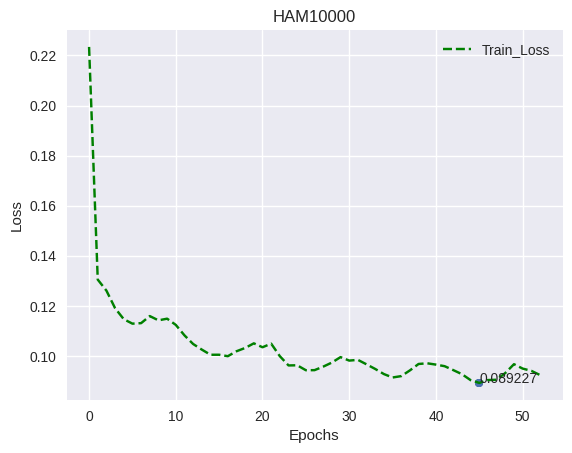

In [24]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

FileNotFoundError: [Errno 2] No such file or directory: './tmp/HAM10000/0829_234419/test_Acc.png'

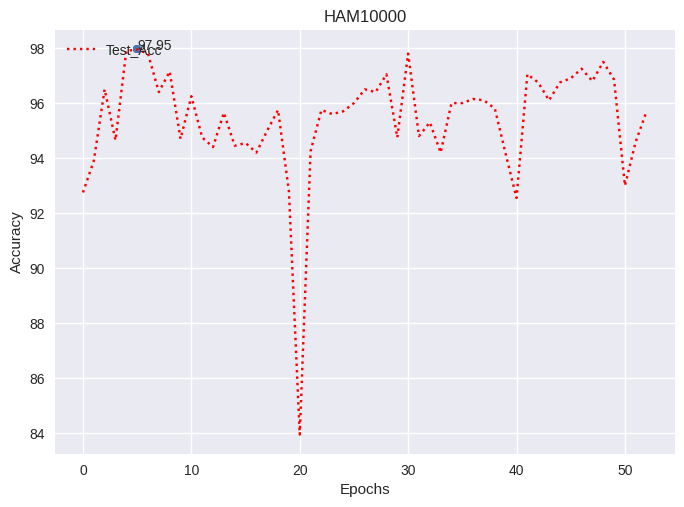

In [25]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [ ]:
network.load_state_dict(torch.load(save_PATH))
for i in range(5):
    test()

In [ ]:
self_scores()

In [ ]:
confusion_matrix(evl_result)

In [ ]:
# #save
s1 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s1)
s2 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s2)

In [ ]:
torch.cuda.memory.empty_cache()